In [12]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*5
presets = 'best_quality'

do_drop_ds = False

use_groups = False
n_groups = 8

auto_stack = False
num_stack_levels = 0
num_bag_folds = 0
if auto_stack:
    num_stack_levels = None
    num_bag_folds = None

use_tune_data = True
tune_length = 24*30*3 # 3 months from end
holdout_frac = None
use_bag_holdout = True

sample_weight = 'sample_weight' #None
weight_evaluation = True #False

run_analysis = False

In [13]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0].copy()
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")

    # add sample weights, which are 1 for observed and 3 for estimated
    X_train_observed["sample_weight"] = 1
    X_train_estimated["sample_weight"] = 3
    X_test["sample_weight"] = 3

    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
    # the filled once will get dropped later anyways, when we drop y nans
    X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])

    # fill missng sample_weight with 3
    #X_train["sample_weight"] = X_train["sample_weight"].fillna(0)
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in sample_weight
    print(f"Number of nans in sample_weight: {X_train['sample_weight'].isna().sum()}")
    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Number of nans in sample_weight: 0
Number of nans in y: 0
Processing location B...
Number of nans in sample_weight: 0
Number of nans in y: 4
Processing location C...
Number of nans in sample_weight: 0
Number of nans in y: 6059


# Feature enginering

In [14]:
import numpy as np
import pandas as pd

X_train.dropna(subset=['y'], inplace=True)

if not do_drop_ds:
    # add hour datetime feature
    X_train["hour"] = X_train.index.hour
    X_test["hour"] = X_test.index.hour

#print(X_train.head())



if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)





to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

In [15]:

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame
import numpy as np
train_data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data = train_data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_length)
train_set = TabularDataset(train_data[train_data["ds"] < split_time])
tune_set = TabularDataset(train_data[train_data["ds"] >= split_time])
if use_groups:
    tune_set = tune_set.drop(columns=['group'])

if do_drop_ds:
    train_set = train_set.drop(columns=['ds'])
    tune_set = tune_set.drop(columns=['ds'])
    train_data = train_data.drop(columns=['ds'])

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
train_set["sample_weight"] = train_set["sample_weight"] / train_set["sample_weight"].sum() * len(train_set)
tune_set["sample_weight"] = tune_set["sample_weight"] / tune_set["sample_weight"].sum() * len(tune_set)
train_data["sample_weight"] = train_data["sample_weight"] / train_data["sample_weight"].sum() * len(train_data)



Loaded data from: X_train_raw.csv | Columns = 49 / 49 | Rows = 92951 -> 92951


In [16]:
if run_analysis:
    import autogluon.eda.auto as auto
    auto.dataset_overview(train_data=X_train, test_data=X_test, label="y", sample=None)

In [17]:
if run_analysis:
    auto.target_analysis(train_data=X_train, label="y")

# Starting

In [18]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 82
Now creating submission number: 83
New filename: submission_83_jorge


In [19]:
predictors = [None, None, None]

In [20]:
def fit_predictor_for_location(loc):
    print(f"Training model for location {loc}...")
    return TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
        sample_weight=sample_weight, 
        weight_evaluation=weight_evaluation, 
        groups="group" if use_groups else None,
    ).fit(
        train_data= train_data[train_data["location"] == loc] if not use_tune_data else train_set[train_set["location"] == loc],
        time_limit=time_limit, 
        #presets=presets, 
        num_stack_levels=num_stack_levels, 
        num_bag_folds=num_bag_folds if not use_groups else None,
        tuning_data=tune_set[tune_set["location"] == loc] if use_tune_data else None,
        use_bag_holdout=True if use_bag_holdout else False,
        holdout_frac=holdout_frac,
    )

loc = "A"
predictors[0] = fit_predictor_for_location(loc)

Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/submission_83_jorge_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   7.00 GB / 494.38 GB (1.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    31900
Train Data Columns: 48
Tuning Data Rows:    2161
Tuning Data Columns: 48
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 633.132, 1

Training model for location A...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 2): ['elevation:m', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('datetime', []) :  1 | ['ds']
		('float', [])    : 42 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])      :  2 | ['estimated_diff_hours'

In [ ]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)

Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/submission_83_jorge_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   7.16 GB / 494.38 GB (1.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    87160
Train Data Columns: 48
Tuning Data Rows:    5791
Tuning Data Columns: 48
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, -0.0, 288.17846

Training model for location B...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('datetime', []) :  1 | ['ds']
		('float', [])    : 43 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])      :  2 | ['estimated_diff_hours', 'hour']
		('object', [])   :  1 | ['location']
	Types of features in processed data (raw dtype, special dtypes):
		('category', [])             :  1 | ['location']
		('float', [])                : 41 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])                  :  2 | ['estimated_diff_hours', 'hour']
		('int', ['bool'])            :  2 | ['is_day:idx', 'is_in_shadow:idx']
		('int', ['

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 loc = "B"                                                                                    │
│ ❱ 2 predictors[1] = fit_predictor_for_location(loc)                                              │
│   3                                                                                              │
│                                                                                                  │
│ in fit_predictor_for_location:3                                                                  │
│                                                                                                  │
│    1 def fit_predictor_for_location(loc):                                                        │
│    2 │   print(f"Training model for location {loc}...")                                          │
│ ❱  3 │   return TabularPredictor(                                                                │
│    4 │   │   label=label,                                                                        │
│    5 │   │   eval_metric=metric,                                                                 │
│    6 │   │   path=f"AutogluonModels/{new_filename}_{loc}",                                       │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/core/utils/decorators.py: │
│ 31 in _call                                                                                      │
│                                                                                                  │
│   28 │   │   @functools.wraps(f)                                                                 │
│   29 │   │   def _call(*args, **kwargs):                                                         │
│   30 │   │   │   gargs, gkwargs = g(*other_args, *args, **kwargs)                                │
│ ❱ 31 │   │   │   return f(*gargs, **gkwargs)                                                     │
│   32 │   │                                                                                       │
│   33 │   │   return _call                                                                        │
│   34                                                                                             │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/predictor/predict │
│ or.py:986 in fit                                                                                 │
│                                                                                                  │
│    983 │   │   if fit_weighted_ensemble is False:                                                │
│    984 │   │   │   aux_kwargs["fit_weighted_ensemble"] = False                                   │
│    985 │   │   self.save(silent=True)  # Save predictor to disk to enable prediction and traini  │
│ ❱  986 │   │   self._learner.fit(                                                                │
│    987 │   │   │   X=train_data,                                                                 │
│    988 │   │   │   X_val=tuning_data,                                                            │
│    989 │   │   │   X_unlabeled=unlabeled_data,                                                   │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/autogluon/tabular/learner/abstract_ │
│ learner.py:159 in fit                                      

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)

Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_82_jorge_C/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   8.31 GB / 494.38 GB (1.7%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    26071
Train Data Columns: 48
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 77.70004, 165.87752)
	If 'regression' is not the correct 

Training model for location C...


	-23.9356	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	9.68s	 = Validation runtime
Fitting model: KNeighborsDist ... Training model for up to 50.14s of the 50.13s of remaining time.
	-19.0643	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	8.45s	 = Validation runtime
Fitting model: LightGBMXT ... Training model for up to 41.66s of the 41.65s of remaining time.


[1000]	valid_set's l1: 16.3122
[2000]	valid_set's l1: 15.4254
[3000]	valid_set's l1: 15.0286
[4000]	valid_set's l1: 14.7915
[5000]	valid_set's l1: 14.6406
[6000]	valid_set's l1: 14.5736


	Ran out of time, early stopping on iteration 6306. Best iteration is:
	[6244]	valid_set's l1: 14.561
	-14.561	 = Validation score   (-mean_absolute_error)
	42.0s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 59.85s of the -0.89s of remaining time.
	-14.3283	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 60.95s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_82_jorge_C/")


# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 49 / 49 | Rows = 92951 -> 92951
Loaded data from: X_test_raw.csv | Columns = 48 / 48 | Rows = 2160 -> 2160


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

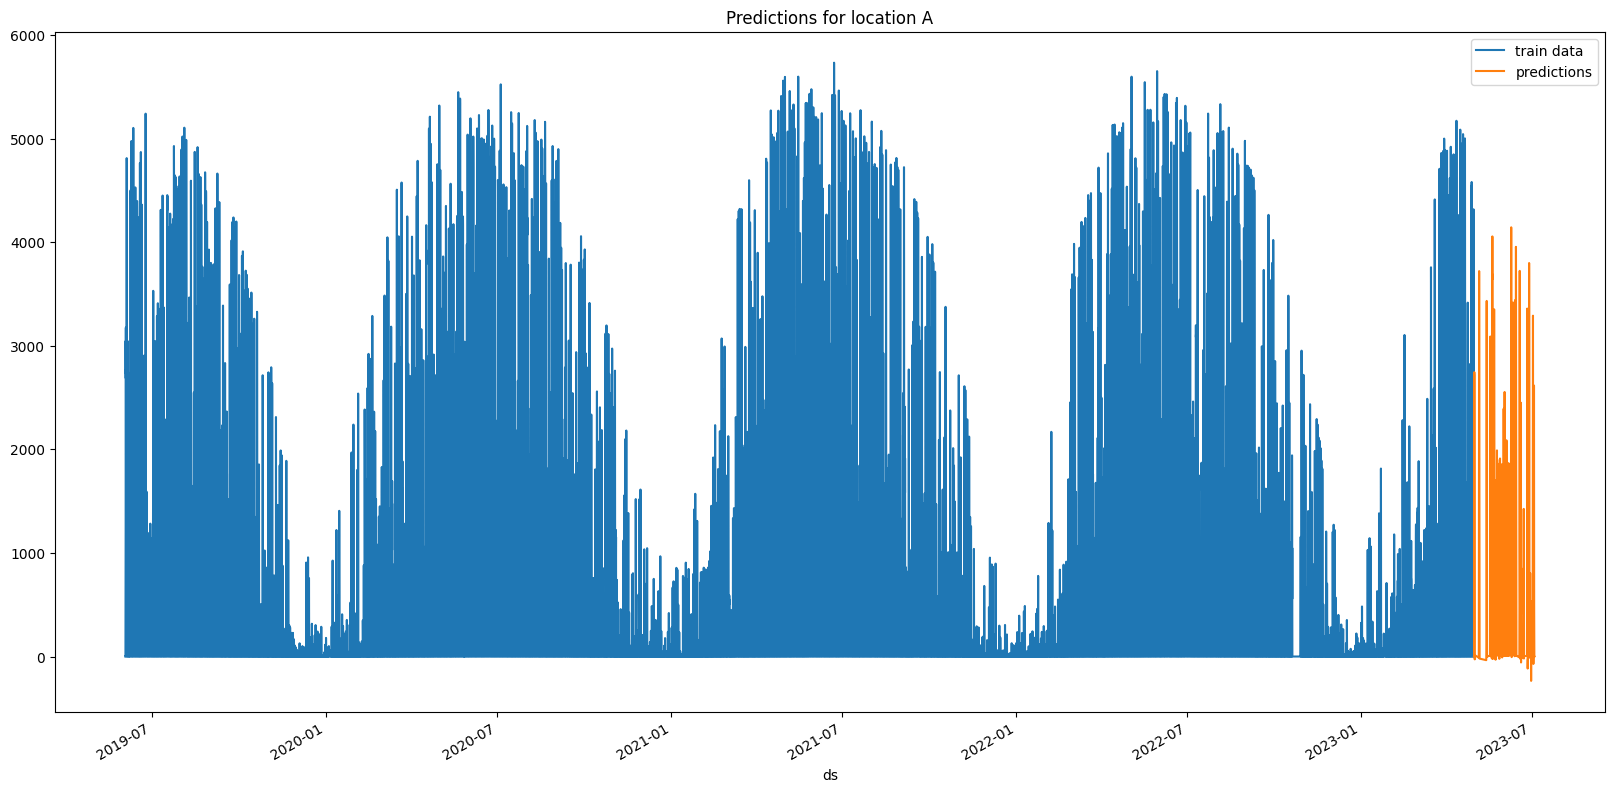

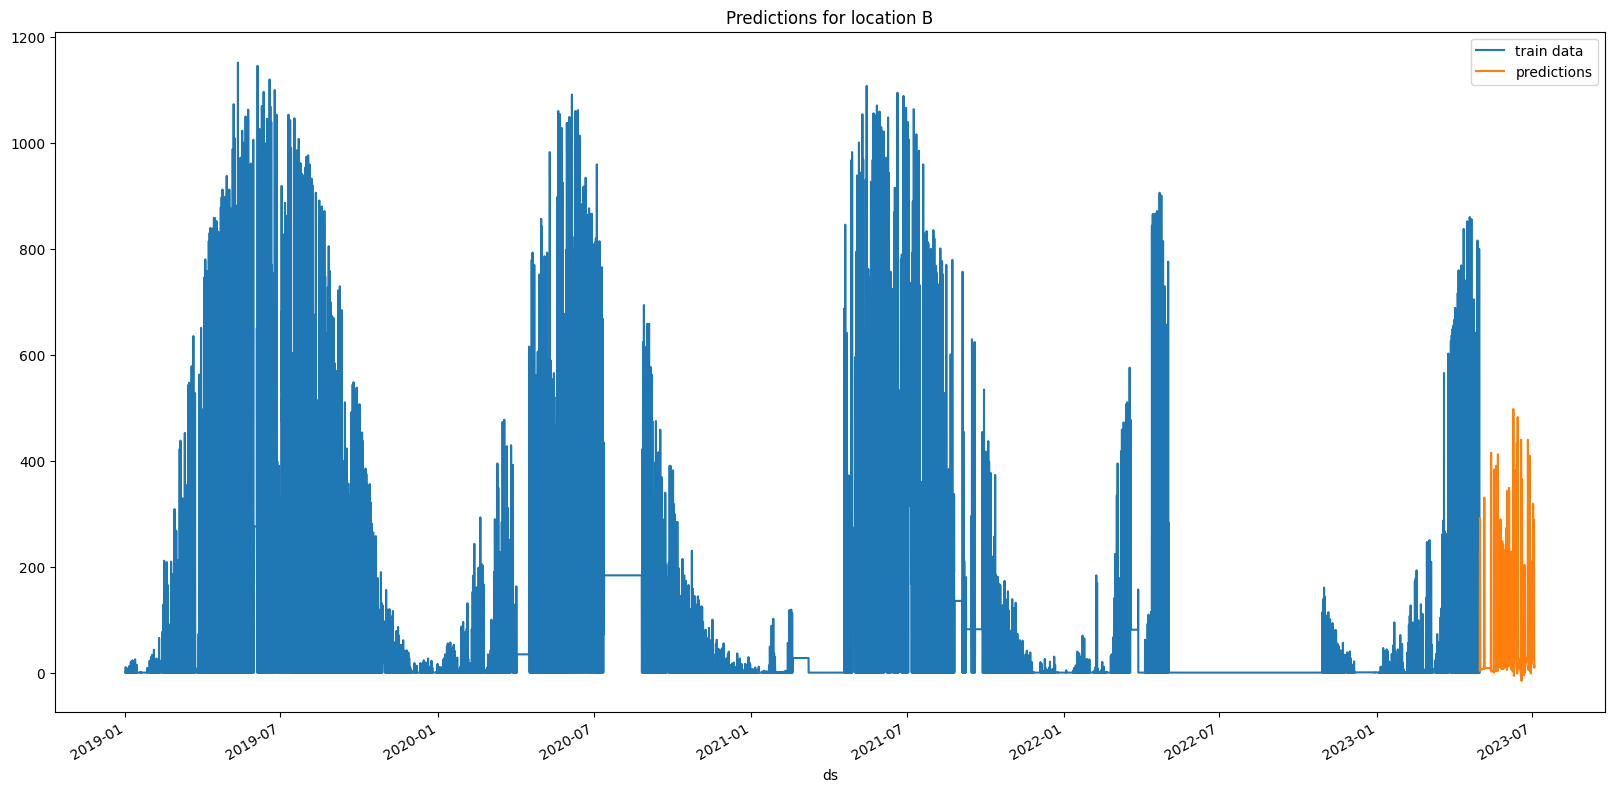

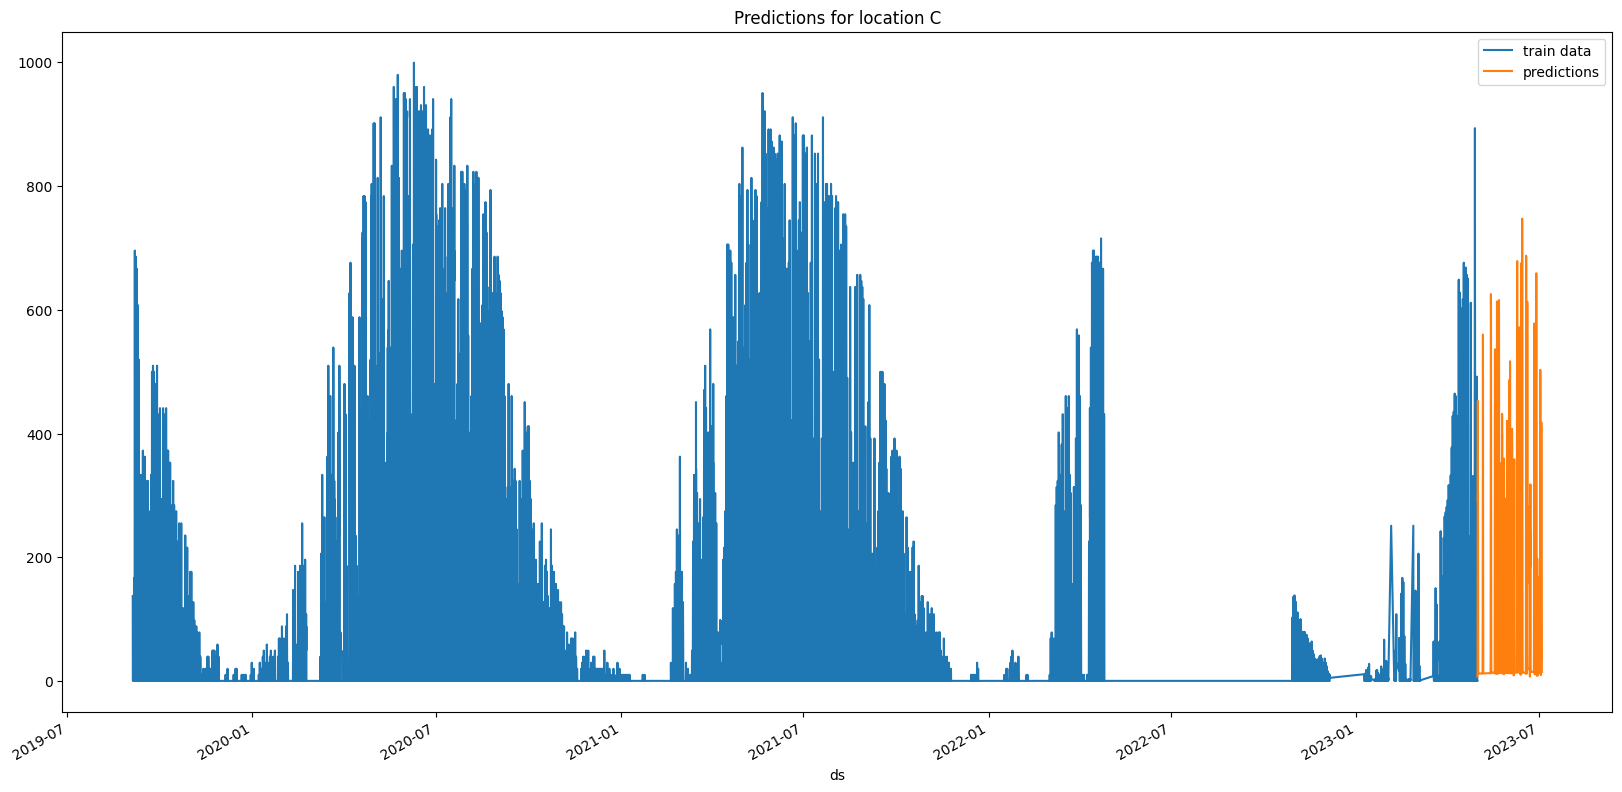

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,3.341963
1,1,3.956671
2,2,6.039295
3,3,56.680393
4,4,233.112457
...,...,...
715,2155,81.470589
716,2156,59.041172
717,2157,30.883743
718,2158,14.709192


In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)
print("jall1a")

Saving submission to submissions/submission_82_jorge.csv
jall1a


In [ ]:
# save this running notebook
from IPython.display import display, Javascript
import time

# hei123

display(Javascript("IPython.notebook.save_checkpoint();"))

time.sleep(3)

<IPython.core.display.Javascript object>

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_82_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_82_jorge_files/notebook_pdfs
[NbConvertApp] Writing 193573 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 194142 bytes to notebook_pdfs/submission_82_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_82_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [ ]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['elevation:m', 'sample_weight', 'location']
Computing feature importance via permutation shuffling for 45 features using 4394 rows with 10 shuffle sets... Time limit: 600s...
	8920.78s	= Expected runtime (892.08s per shuffle set)


In [ ]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictor.feature_importance(feature_stage="original", data=observed, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['elevation:m', 'sample_weight', 'location', 'group']
Computing feature importance via permutation shuffling for 45 features using 5000 rows with 10 shuffle sets... Time limit: 600s...


	1716.43s	= Expected runtime (171.64s per shuffle set)
	540.67s	= Actual runtime (Completed 6 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
sun_elevation:d,3.990541e+01,1.409081e+00,5.894534e-09,6,4.222492e+01,3.758590e+01
clear_sky_rad:W,3.300994e+01,1.316396e+00,1.082364e-08,6,3.517688e+01,3.084300e+01
direct_rad:W,1.455438e+01,9.510883e-01,1.272696e-07,6,1.611999e+01,1.298878e+01
clear_sky_energy_1h:J,1.273177e+01,6.361134e-01,3.335724e-08,6,1.377889e+01,1.168466e+01
diffuse_rad:W,1.054518e+01,4.253884e-01,1.146285e-08,6,1.124542e+01,9.844941e+00
direct_rad_1h:J,6.190405e+00,4.816393e-01,3.035476e-07,6,6.983239e+00,5.397571e+00
diffuse_rad_1h:J,3.482767e+00,2.930514e-01,4.482475e-07,6,3.965163e+00,3.000370e+00
is_in_shadow:idx,1.776624e+00,8.891051e-02,3.363125e-08,6,1.922981e+00,1.630267e+00
relative_humidity_1000hPa:p,1.166302e+00,2.278424e-01,2.863276e-05,6,1.541357e+00,7.912468e-01
snow_water:kgm2,1.147657e+00,1.311319e-01,2.047881e-06,6,1.363515e+00,9.317989e-01


In [ ]:
display(Javascript("IPython.notebook.save_checkpoint();"))
time.sleep(3)

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_81_jorge_with_feature_importance_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_81_jorge_with_feature_importance_files/notebook_pdfs
[NbConvertApp] Writing 135013 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 284295 bytes to notebook_pdfs/submission_81_jorge_with_feature_importance.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_81_jorge_with_feature_importance.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [ ]:
# import subprocess

# def execute_git_command(directory, command):
#     """Execute a Git command in the specified directory."""
#     try:
#         result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
#         return result.decode('utf-8').strip(), True
#     except subprocess.CalledProcessError as e:
#         print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
#         return e.output.decode('utf-8').strip(), False

# git_repo_path = "."

# execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
# execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

# branch_name = new_filename

# # add datetime to branch name
# branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# commit_msg = "run result"

# execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# # Navigate to your repo and commit changes
# execute_git_command(git_repo_path, ['add', '.'])
# execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# # Push to remote
# output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# # If the push fails, try setting an upstream branch and push again
# if not success and 'upstream' in output:
#     print("Attempting to set upstream and push again...")
#     execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
#     execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

# execute_git_command(git_repo_path, ['checkout', 'main'])